# Text exploration

This is a notebook for *looking* at the text data so we can make descisions about how to clean and process the data to be used for clustering in.

**The actual preprocessing done to create the dataset we use throughout the codebase can be found in `preprocessing.py`**  

The preprocessing will be done exploratory here, and then in `preprocessing.py` to create the data that will be and saved to a file to be used for recommendation in `recommend.py`. 

Expect some duplicate code between here and `.py` files.

#### Our exploratory analysis includes looking at:
- Statistics
    - Length of texts, etc.
- Cleaning
- Reducing data
    - Only use X first sentences
- Stemming
- Tokenizing

In [1]:
import re
import random
import string

import matplotlib.pyplot as plt
import numpy as np

from nltk.corpus import stopwords as sw
from nltk.stem import PorterStemmer
from sklearn.decomposition import PCA

from utils.read_data import read_articles_file

In [2]:
# Initialize stemmer and stopwords
stemmer = PorterStemmer()
stopwords = set(sw.words("english"))

In [3]:
def pca(X, labels, title = "", n_components = 2, figsize = (5,5)):
    """ Function for using the sklearn pca function for visualizing our clusteirng in 2D """
    plt.figure(figsize = figsize)
    pca = PCA(n_components = n_components)
    X_pca = pca.fit(X).transform(X) if type(X) == np.ndarray else pca.fit(X.toarray()).transform(X.toarray())

    x, y = X_pca.T
    labels = labels if type(labels) == list else labels.tolist()
    scatter = plt.scatter(x, y, c = labels, cmap="Set1", label = labels)
    plt.legend(*scatter.legend_elements())

    plt.title(title)
    plt.show()

## Read data

In [4]:
N = 1000

article_texts_path = "/work3/s204163/wiki/article_texts"
article_ids_path = "/work3/s204163/wiki/article_ids"

all_articles = read_articles_file(article_texts_path, return_titles = False, read_titles = True)

### Text processing

In [5]:
# Translator for removing punctuation, including non unicode U+2013 character "–", very common
punctuation_translator = str.maketrans(string.punctuation + '\u2013', " " * (len(string.punctuation) + 1))

def remove_numbers(text:str) -> str:
    """ Match all digits in the string and replace them with an empty string """
    new_text = re.sub(r'[0-9]', ' ', text)
    return new_text


def remove_blank_space(text: str) -> str:
    """ Stolen from: https://stackoverflow.com/a/1546244"""
    # return re.sub(' +', ' ', text)        # Doesnt really work
    # return re.sub(' {2,}', ' ', text)     # Doesnt really work
    return " ".join(text.split()) # TODO: Slooowwwwww


def clean(text: str) -> str:
    """ Strip the text of punctutaion, numbers, excessive spaces, etc. """
    text = remove_numbers(text)                                         # remove numbers
    text = text.translate(punctuation_translator)                       # remove punctuation: !"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~
    text = text.lower()                                                 # convert to lower case
    text = remove_blank_space(text)                                     # remove double+ spacing
    text = text.strip()                                                 # remove newline characters and spaces
    return text

In [6]:
def preprocess(text: str) -> str:
    """
    Do preprocessing which includes:
        - cleaning text
        - removing stop words
        - stemming words
    """
    text = clean(text)
    
    # Do stop word removal and stemming in one pass, looks messy saves some time
    words = text.split()
    return " ".join([stemmer.stem(word) for word in words if not word in stopwords])


def random_articles(articles: set, N : int, seed: int = 0) -> set:
    """ Return a subset of N random articles """
    random.seed(seed)
    random_keys = random.sample(list(articles.keys()), N)

    return { key : articles[key] for key in random_keys }

### Random sample a subset of data

In [7]:
# Sample N articles 
raw_articles = random_articles(all_articles, N = N)

# Grab the raw text from the articles and do preprocessing
raw_corpus = list(raw_articles.values())
corpus = [preprocess(text) for text in raw_corpus]

# Print a small sample
for raw_text, text in zip(raw_corpus[:5], corpus[:5]):
    print(f"original  : {raw_text[:100]}")
    print(f"processed : {text[:100]}")
    print("-" * 100)

original  : Princes Street (often misspelt as "Princess Street") is a major street in Dunedin, the second larges
processed : princ street often misspelt princess street major street dunedin second largest citi south island ne
----------------------------------------------------------------------------------------------------
original  : thumb|right|The Rev. Samuel Merrill Woodbridge, c. late 1860s|alt=Nineteenth century black-and-white
processed : thumb right rev samuel merril woodbridg c late alt nineteenth centuri black white photograph samuel 
----------------------------------------------------------------------------------------------------
original  : "All Hell Breaks Loose" is the joint title for the two-part second-season finale of The CW televisio
processed : hell break loos joint titl two part second season final cw televis seri supernatur consist twenti fi
----------------------------------------------------------------------------------------------------
original  : John Ad

## Visualize data
#### Lengths

In [8]:
raw_text_n_chars = [len(text) for text in raw_corpus if len(text)]
raw_text_n_words = [len(text.split()) for text in raw_corpus]

text_n_chars = [len(text) for text in corpus if len(text)]
text_n_words = [len(text.split()) for text in corpus]

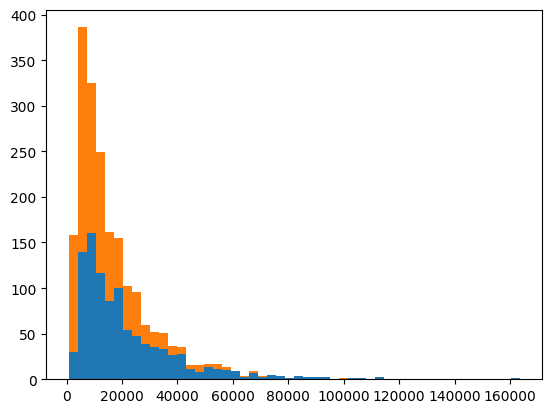

In [9]:
plt.hist([raw_text_n_chars, text_n_chars], 50, stacked= True)
plt.show()

## Shorten texts

In [10]:
def shorten_texts(corpus: list, max_chars: int = 10_000):
    return [text[:max_chars] for text in corpus]

corpus = shorten_texts(corpus)

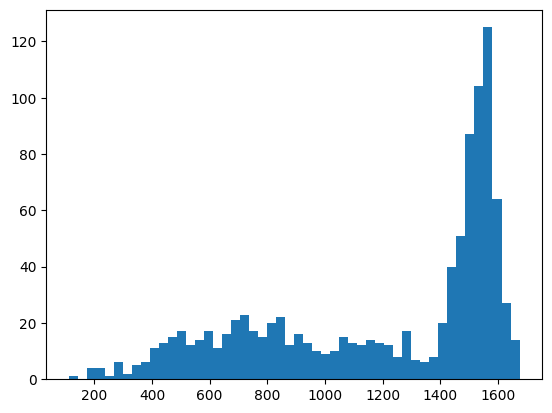

In [11]:
plt.hist([len(text.split()) for text in corpus], 50)
plt.show()